In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
# %qtconsole

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

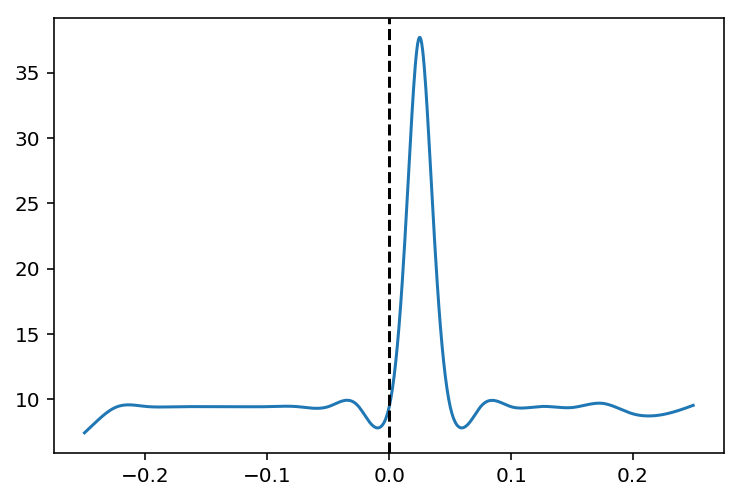

In [3]:
from scipy.stats import norm
from patsy import dmatrix

sampling_frequency = 1500
total_time = 0.5 # second
n_time = int(sampling_frequency * total_time)
n_trials = 1000
time = np.arange(n_time) / sampling_frequency - total_time / 2

t = (time[:, np.newaxis] * np.ones((1, n_trials))).ravel('F')

knot_spacing = 0.025
n_steps = (time[-1] - time[0]) // knot_spacing
time_knots = time[0] + np.arange(1, n_steps) * knot_spacing

FORMULA = '1 + cr(time, knots=time_knots, constraints="center")'
design_matrix = dmatrix(FORMULA, dict(time=t))
baseline_rate = 10
coefficients = np.zeros((design_matrix.shape[1],))
coefficients[0] = np.log(baseline_rate / sampling_frequency)

coefficients[(coefficients.size // 2) + 1] = np.log(4)

rate = np.exp(design_matrix @ coefficients) * sampling_frequency

fig, ax = plt.subplots(1, 1)
ax.plot(time, rate[:n_time])
ax.axvline(0, color='black', linestyle='--')

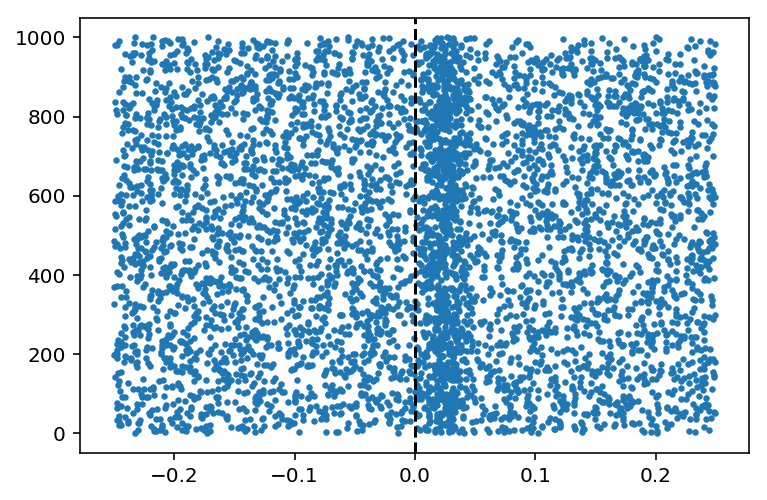

In [4]:
def get_spikes(rate, sampling_frequency=1500):
    return np.random.poisson(rate / sampling_frequency)

spikes1 = get_spikes(rate, sampling_frequency)
spike_ind, trial_ind = np.nonzero(np.reshape(spikes1, (n_time, n_trials), order='F'))

fig, ax = plt.subplots(1, 1)
ax.scatter(time[spike_ind], trial_ind + 1, s=5)
ax.axvline(0, color='black', linestyle='--')

/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


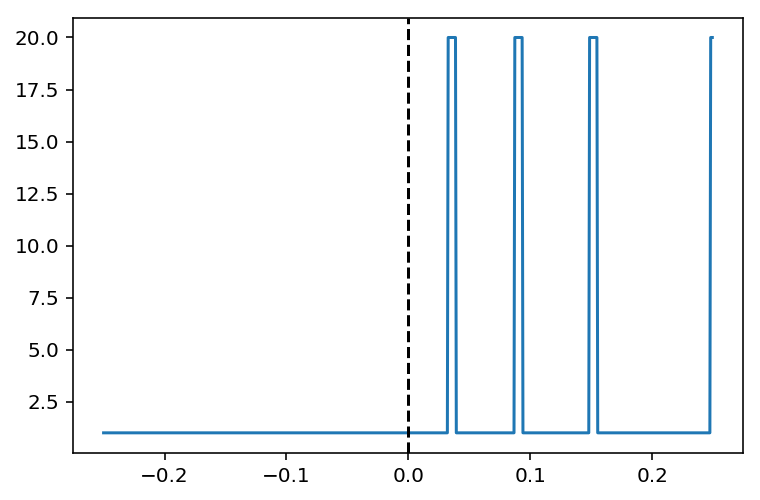

In [5]:
from src.spike_models import lag

trial_id = (np.arange(n_trials)[np.newaxis] * np.ones((n_time, 1))).ravel('F')
lagged_spikes = lag(spikes1, trial_id=trial_id, n_lags=100).values
lagged_spikes[t < 0] = 0

FORMULA = '1 + lagged_spikes'
design_matrix = dmatrix(FORMULA, dict(lagged_spikes=lagged_spikes))

baseline_rate = 1
coefficients = np.zeros((design_matrix.shape[1],))
coefficients[0] = np.log(baseline_rate / sampling_frequency)
coefficients[70:80] = np.log(20)

rate = np.exp(design_matrix @ coefficients) * sampling_frequency

fig, ax = plt.subplots(1, 1)
ax.plot(time, rate[:n_time])
ax.axvline(0, color='black', linestyle='--')

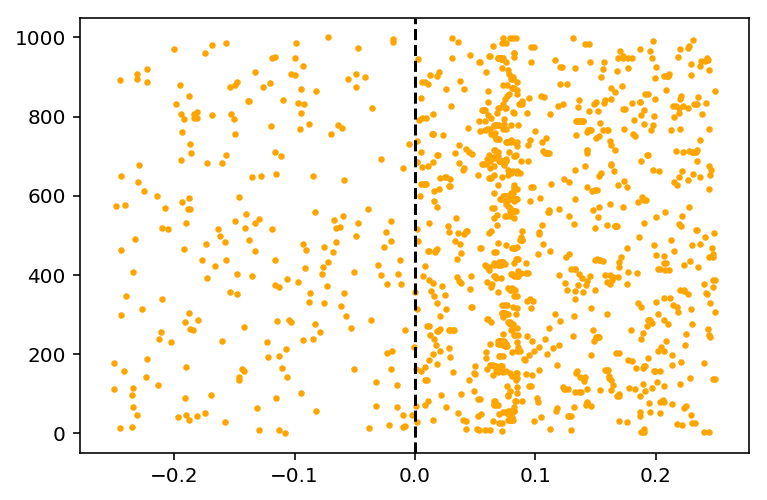

In [6]:
spikes2 = get_spikes(rate, sampling_frequency)
spike_ind, trial_ind = np.nonzero(np.reshape(spikes2, (n_time, n_trials), order='F'))

fig, ax = plt.subplots(1, 1)
ax.scatter(time[spike_ind], trial_ind + 1, s=5, color='orange')
ax.axvline(0, color='black', linestyle='--')

In [7]:
from spectral_connectivity import Multitaper, Connectivity

spikes = np.stack((spikes1.reshape((n_time, n_trials), order='F'),
                   spikes2.reshape((n_time, n_trials), order='F')), axis=-1)

m = Multitaper(spikes, sampling_frequency, time_window_duration=total_time / 2,
               time_halfbandwidth_product=2)
c = Connectivity.from_multitaper(m)

print(m.frequency_resolution)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=2,
           time_window_duration=0.25, time_window_step=0.25,
           detrend_type='constant', start_time=0, n_tapers=3)


8.0


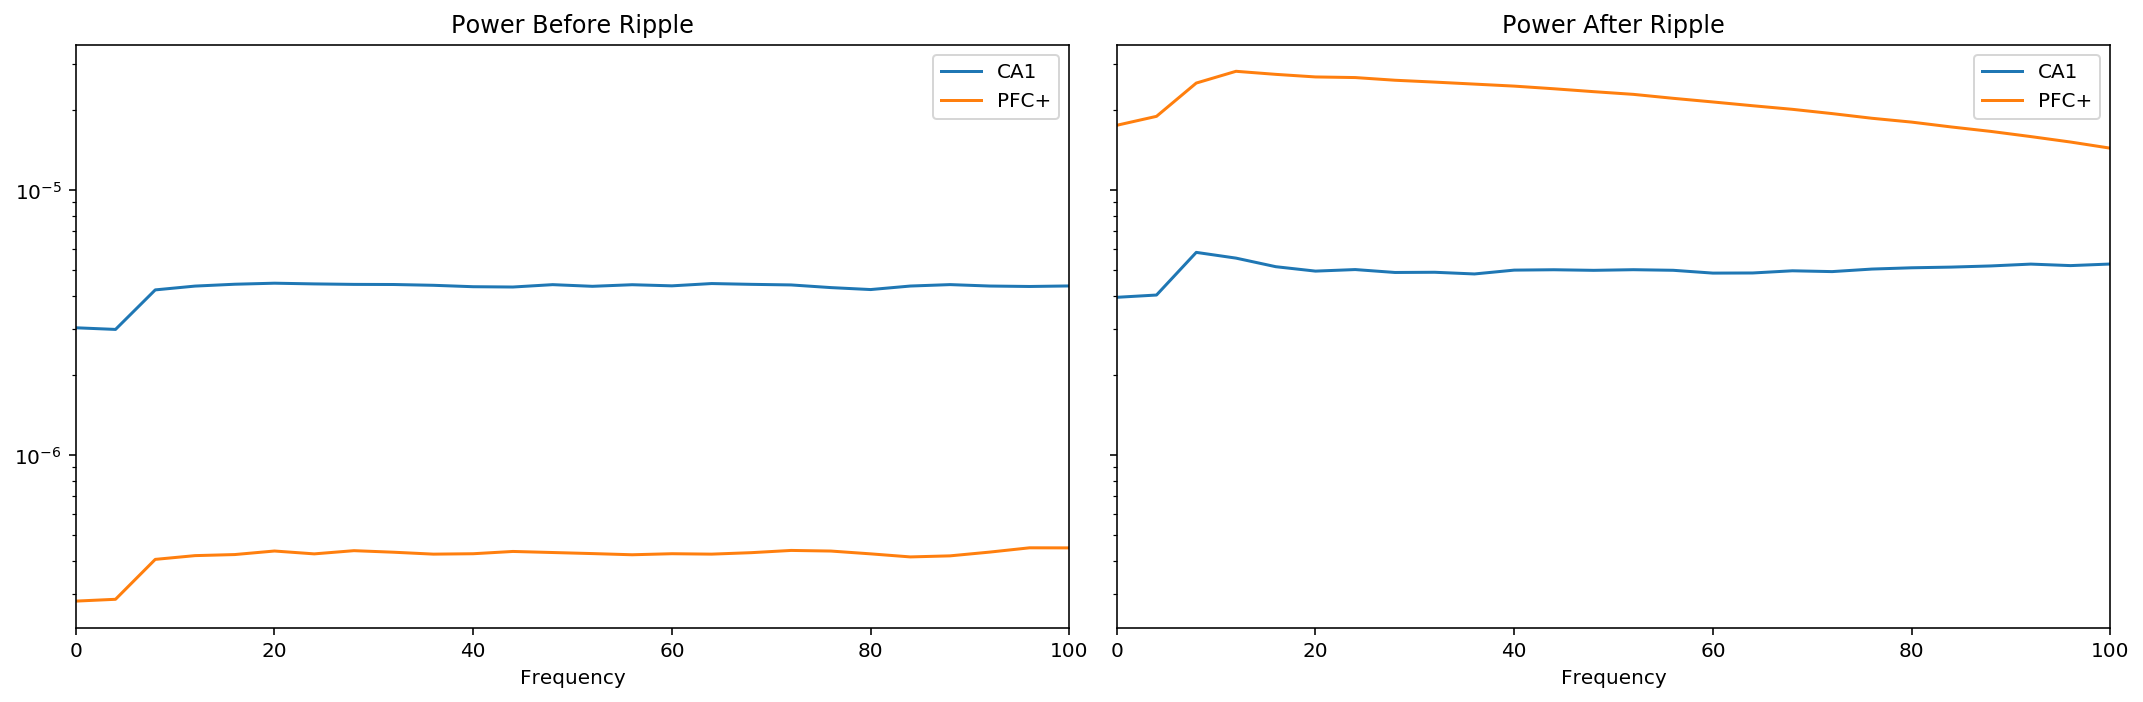

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
h = axes[0].semilogy(c.frequencies, c.power()[0, ...])
axes[0].legend(h, ['CA1', 'PFC+'])
axes[0].set_title('Power Before Ripple')
axes[0].set_xlabel('Frequency')
axes[1].set_xlabel('Power')

h = axes[1].semilogy(c.frequencies, c.power()[1, ...])
axes[1].legend(h, ['CA1', 'PFC+'])
axes[1].set_title('Power After Ripple');
axes[1].set_xlabel('Frequency')

plt.xlim((0, 100))
plt.tight_layout()

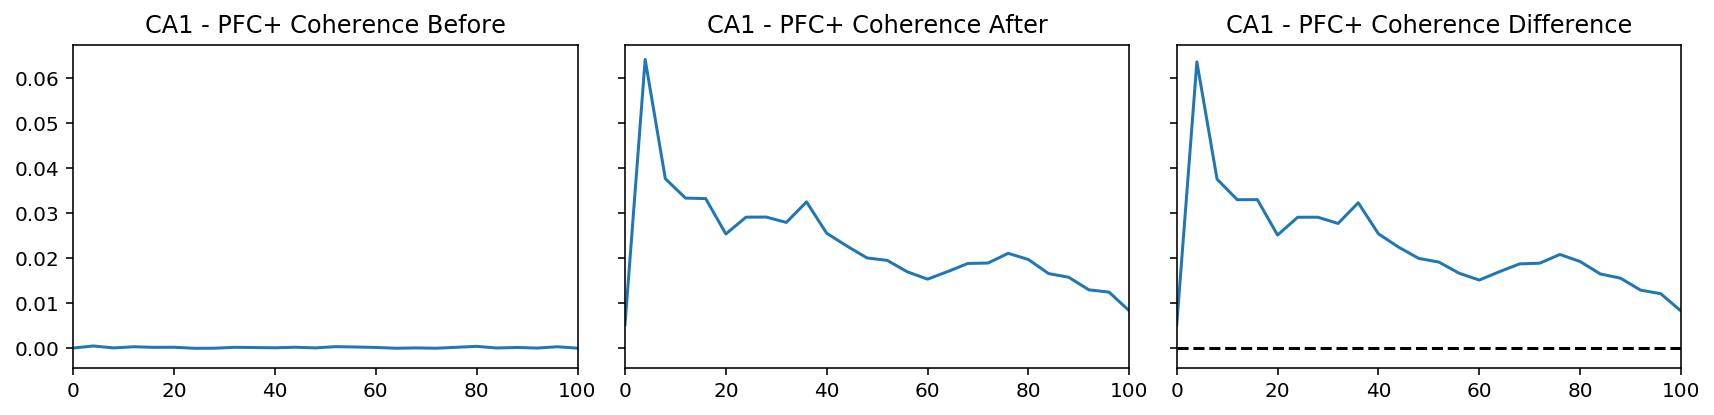

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)

coherence_magnitude = c.coherence_magnitude()
coherence_change = np.diff(coherence_magnitude, axis=0)

# Before
axes[0].plot(c.frequencies, coherence_magnitude[0, :, 0, 1])
axes[0].set_title('CA1 - PFC+ Coherence Before')


# After
axes[1].plot(c.frequencies, coherence_magnitude[1, :, 0, 1])
axes[1].set_title('CA1 - PFC+ Coherence After')


# Difference
axes[2].plot(c.frequencies, coherence_change[0, :, 0, 1])
axes[2].set_title('CA1 - PFC+ Coherence Difference')
axes[2].axhline(0, color='black', linestyle='--')

plt.xlim((0, 100))
plt.tight_layout()


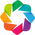

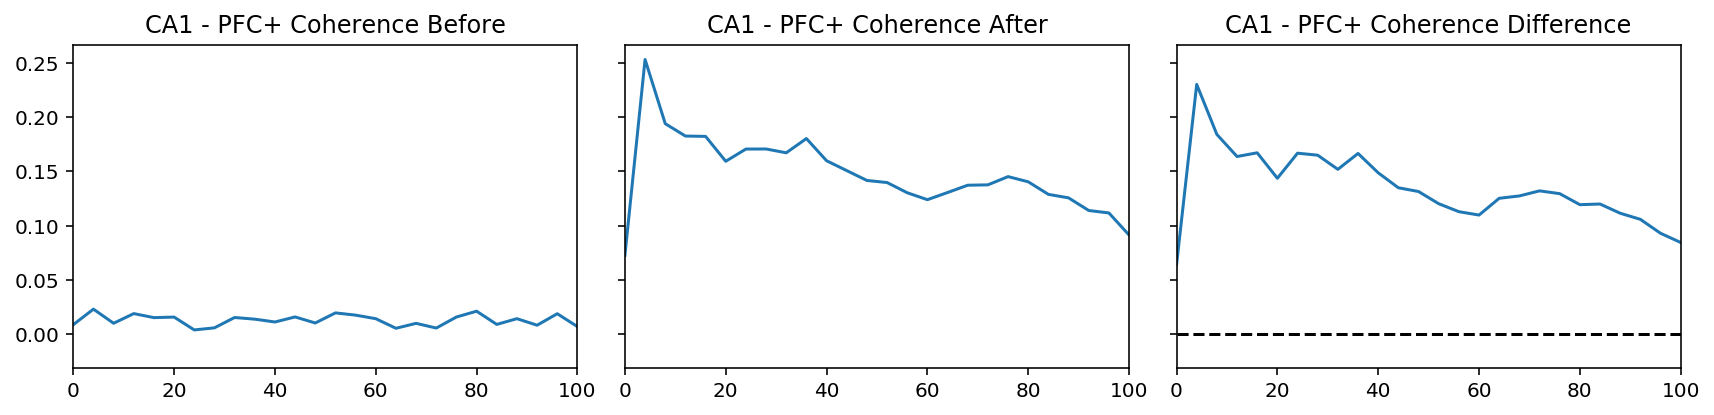

In [10]:
from src.analysis import adjusted_coherence_magnitude

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)

coherence_magnitude = adjusted_coherence_magnitude(
    spikes, sampling_frequency, m, c)
coherence_change = np.diff(coherence_magnitude, axis=0)

# Before
axes[0].plot(c.frequencies, coherence_magnitude[0, :, 0, 1])
axes[0].set_title('CA1 - PFC+ Coherence Before')


# After
axes[1].plot(c.frequencies, coherence_magnitude[1, :, 0, 1])
axes[1].set_title('CA1 - PFC+ Coherence After')


# Difference
axes[2].plot(c.frequencies, coherence_change[0, :, 0, 1])
axes[2].set_title('CA1 - PFC+ Coherence Difference')
axes[2].axhline(0, color='black', linestyle='--')

plt.xlim((0, 100))
plt.tight_layout()